# Understanding Over & Underfitting
## Predicting Boston Housing Prices

## Getting Started
In this project, you will use the Boston Housing Prices dataset to build several models to predict the prices of homes with particular qualities from the suburbs of Boston, MA.
We will build models with several different parameters, which will change the goodness of fit for each. 

---
## Data Exploration
Since we want to predict the value of houses, the **target variable**, `'MEDV'`, will be the variable we seek to predict.

### Import and explore the data. Clean the data for outliers and missing values. 

In [27]:
# Your code here

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('boston_data.csv')

In [3]:
data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.15876,0.0,10.81,0.0,0.413,5.961,17.5,5.2873,4.0,305.0,19.2,376.94,9.88,21.7
1,0.10328,25.0,5.13,0.0,0.453,5.927,47.2,6.9320,8.0,284.0,19.7,396.90,9.22,19.6
2,0.34940,0.0,9.90,0.0,0.544,5.972,76.7,3.1025,4.0,304.0,18.4,396.24,9.97,20.3
3,2.73397,0.0,19.58,0.0,0.871,5.597,94.9,1.5257,5.0,403.0,14.7,351.85,21.45,15.4
4,0.04337,21.0,5.64,0.0,0.439,6.115,63.0,6.8147,4.0,243.0,16.8,393.97,9.43,20.5


In [4]:
data.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
count,404.000000,404.000000,404.000000,404.000000,404.000000,404.00000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000
mean,3.730912,10.509901,11.189901,0.069307,0.556710,6.30145,68.601733,3.799666,9.836634,411.688119,18.444554,355.068243,12.598936,22.312376
std,8.943922,22.053733,6.814909,0.254290,0.117321,0.67583,28.066143,2.109916,8.834741,171.073553,2.150295,94.489572,6.925173,8.837019
min,0.006320,0.000000,0.460000,0.000000,0.392000,3.56100,2.900000,1.169100,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082382,0.000000,5.190000,0.000000,0.453000,5.90275,45.800000,2.087875,4.000000,281.000000,17.375000,374.710000,7.135000,17.100000
50%,0.253715,0.000000,9.795000,0.000000,0.538000,6.23050,76.600000,3.207450,5.000000,330.000000,19.000000,391.065000,11.265000,21.400000
75%,4.053158,12.500000,18.100000,0.000000,0.631000,6.62925,94.150000,5.222125,24.000000,666.000000,20.200000,396.007500,16.910000,25.000000
max,88.976200,95.000000,27.740000,1.000000,0.871000,8.78000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,34.370000,50.000000


In [5]:
data.dtypes

crim       float64
zn         float64
indus      float64
chas       float64
nox        float64
rm         float64
age        float64
dis        float64
rad        float64
tax        float64
ptratio    float64
black      float64
lstat      float64
medv       float64
dtype: object

In [8]:
data.isnull().sum()

crim       0
zn         0
indus      0
chas       0
nox        0
rm         0
age        0
dis        0
rad        0
tax        0
ptratio    0
black      0
lstat      0
medv       0
dtype: int64

In [19]:
data.drop(index=data[data['crim'] == data['crim'].max()].index,inplace=True)

In [24]:
data.drop(index=data[data['zn'] == data['zn'].max()].index,inplace=True)

In [25]:
data.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
count,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.00000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000
mean,3.340938,6.926702,11.585890,0.070681,0.563010,6.274021,70.40288,3.622205,10.065445,414.827225,18.539791,354.044319,12.907016,21.969895
std,6.411095,15.108136,6.666504,0.256627,0.115432,0.664125,27.15351,1.920870,8.861632,172.416746,2.062549,95.236530,6.873265,8.474508
min,0.006320,0.000000,1.250000,0.000000,0.400000,3.561000,2.90000,1.169100,1.000000,188.000000,13.000000,0.320000,1.730000,5.000000
25%,0.092555,0.000000,5.860000,0.000000,0.465250,5.889500,51.20000,2.068525,4.000000,281.750000,17.400000,374.462500,7.457500,16.850000
50%,0.294545,0.000000,9.900000,0.000000,0.538000,6.221000,78.20000,3.095750,5.000000,330.000000,19.100000,390.955000,11.650000,21.200000
75%,4.251580,0.000000,18.100000,0.000000,0.643000,6.592250,94.47500,4.764825,24.000000,666.000000,20.200000,395.930000,17.097500,24.775000
max,51.135800,75.000000,27.740000,1.000000,0.871000,8.780000,100.00000,10.710300,24.000000,711.000000,21.200000,396.900000,34.370000,50.000000


### Next, we want to explore the data. Pick several varibables you think will be ost correlated with the prices of homes in Boston, and create plots that show the data dispersion as well as the regression line of best fit.

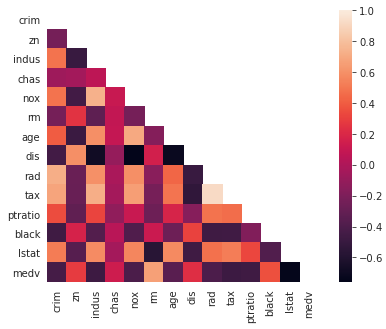

In [30]:
# Your plots here

corr = data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(7, 5))
    ax = sns.heatmap(corr, mask=mask, vmax=1, square=True)



<AxesSubplot:>

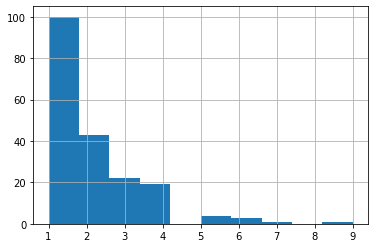

In [32]:
count_classes = pd.value_counts(data['medv'])
count_classes.hist()

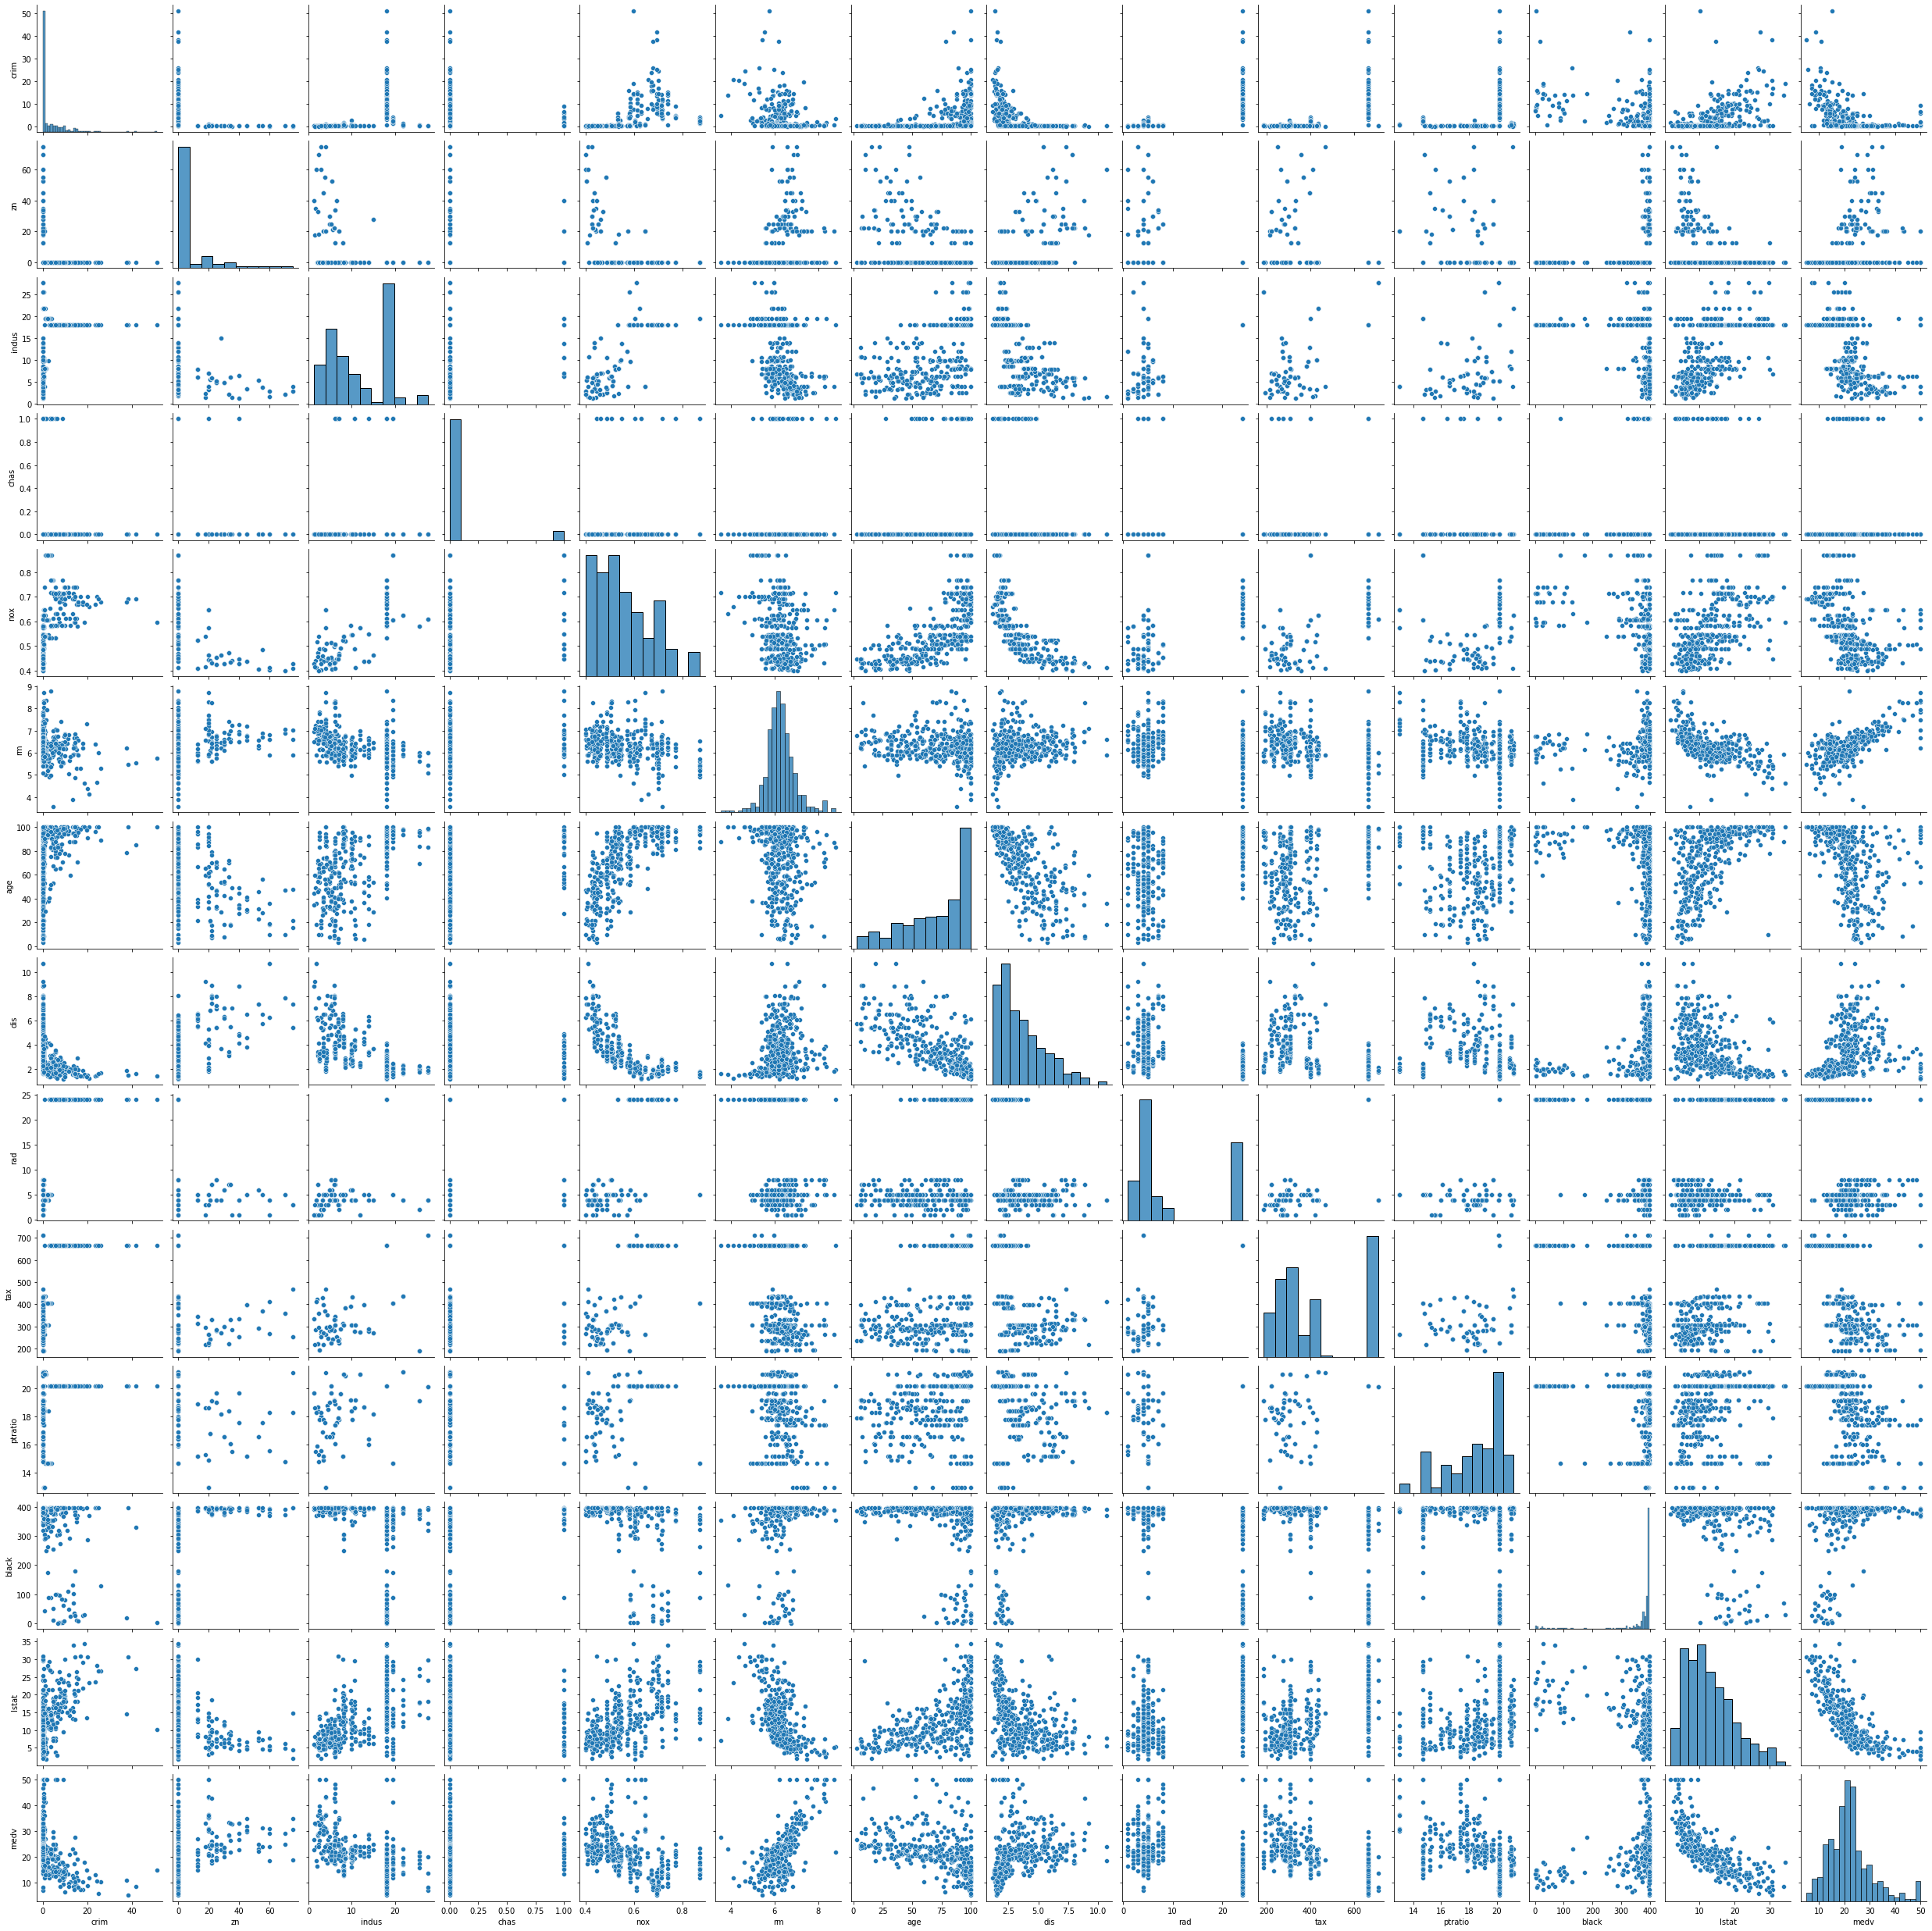

In [33]:
sns.pairplot(data)

In [ ]:
# crim, rm, age, dis, hstat

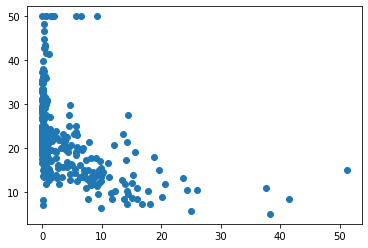

In [35]:
plt.scatter(data['crim'],data['medv'])
plt.show()

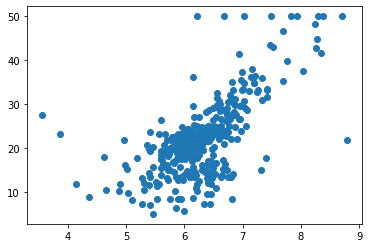

In [36]:
plt.scatter(data['rm'],data['medv'])
plt.show()

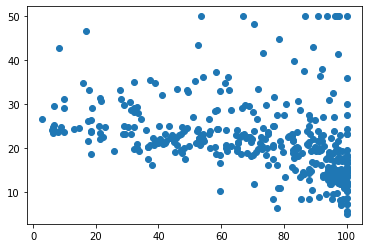

In [37]:
plt.scatter(data['age'],data['medv'])
plt.show()

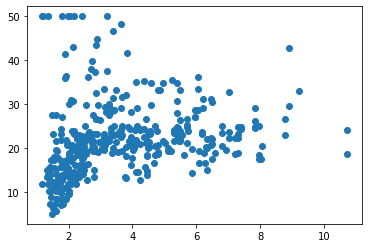

In [39]:
plt.scatter(data['dis'],data['medv'])
plt.show()

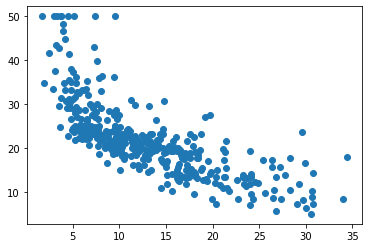

In [40]:
plt.scatter(data['lstat'],data['medv'])
plt.show()

### What do these plots tell you about the relationships between these variables and the prices of homes in Boston? Are these the relationships you expected to see in these variables?

In [ ]:
# Your response here

# there are some features that have positive colliniarity and others that have negative,
# and these ones that i plotted have hight correlation witht the medv.
# also they seem to be the ones that are not 'synthetic', as the shape of the scatter is clearly not following any
# type of random linearity.

### Make a heatmap of the remaining variables. Are there any variables that you did not consider that have very high correlations? What are they?

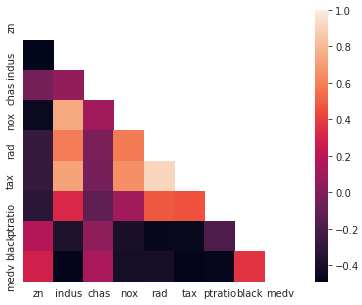

In [42]:
# Your response here

rem = data.drop(columns=['crim', 'rm', 'age', 'dis', 'lstat'])

corr = rem.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(7, 5))
    ax = sns.heatmap(corr, mask=mask, vmax=1, square=True)


In [ ]:
# yes i still have variables that have high correlation with medv,
# but im not considering them because of their distribution plot
# we can see that they have some synthetic shape.

### Calculate Statistics
Calculate descriptive statistics for housing price. Include the minimum, maximum, mean, median, and standard deviation. 

In [43]:
# Your code here

data['medv'].describe()

count    382.000000
mean      21.969895
std        8.474508
min        5.000000
25%       16.850000
50%       21.200000
75%       24.775000
max       50.000000
Name: medv, dtype: float64

In [45]:
# only the features that i want

data = data[['crim', 'rm', 'age', 'dis', 'lstat','medv']]

----

## Developing a Model

### Implementation: Define a Performance Metric
What is the performance meteric with which you will determine the performance of your model? Create a function that calculates this performance metric, and then returns the score. 

In [47]:
from sklearn.metrics import r2_score


def performance_metric(x, y):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    # Your code here:
    return print("r2_score: ",r2_score(x,y))


### Implementation: Shuffle and Split Data
Split the data into the testing and training datasets. Shuffle the data as well to remove any bias in selecting the traing and test. 

In [46]:
# Your code here

from sklearn.model_selection import train_test_split

X = data.drop(columns='medv')

y = data['medv']

X_train, X_test, y_train, y_test = train_test_split(X, y,random_state = 0, test_size = 0.20, shuffle=True)

----

## Analyzing Model Performance
Next, we are going to build a Random Forest Regressor, and test its performance with several different parameter settings.

### Learning Curves
Lets build the different models. Set the max_depth parameter to 2, 4, 6, 8, and 10 respectively. 

In [55]:
# Five separate RFR here with the given max depths

from sklearn.ensemble import RandomForestRegressor


list1 = [2, 4, 6, 8, 10]

for element in list1:
    forest = RandomForestRegressor(n_estimators=10, 
                                   max_depth=element, 
                                   random_state=1) 
    forest = forest.fit(X_train, y_train)
    pred = forest.predict(X_test)
    print(element)
    performance_metric(y_test, pred)
    

2
r2_score:  0.679504334216556
4
r2_score:  0.8337912964745691
6
r2_score:  0.8393792260026638
8
r2_score:  0.8159967166712978
10
r2_score:  0.8258512746052825


Now, plot the score for each tree on the training set and on the testing set.

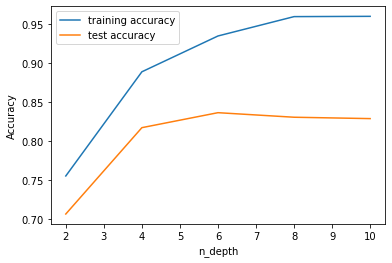

In [61]:
# Produce a plot with the score for the testing and training for the different max depths
max_depth = [2, 4, 6, 8, 10]
test = []
train = []

for depth in max_depth:
    model = RandomForestRegressor(max_depth= depth)
    model.fit(X_train, y_train)
    test.append(model.score(X_test,y_test))
    train.append(model.score(X_train,y_train))

plt.plot(max_depth, train, label="training accuracy")
plt.plot(max_depth, test, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_depth")
plt.legend()

What do these results tell you about the effect of the depth of the trees on the performance of the model?

In [ ]:
# Your response here

# the depth 6 is propably the best depth.



### Bias-Variance Tradeoff
When the model is trained with a maximum depth of 1, does the model suffer from high bias or from high variance? How about when the model is trained with a maximum depth of 10? Check out this article before answering: https://towardsdatascience.com/understanding-the-bias-variance-tradeoff-165e6942b229

In [ ]:
# Your response here

# low maximum depth will get low variance but high bias, 
# the model will know close to nothing about the dataset and will assume a lot
# high maximum depth will get low bias but high variance, 
# in this case the model will be an expert on the dataset but will suffer with new data.

### Best-Guess Optimal Model
What is the max_depth parameter that you think would optimize the model? Run your model and explain its performance.

In [64]:
# Your response here

forest = RandomForestRegressor(n_estimators=10,
                               max_depth=6, 
                               random_state=1)
pred = forest.predict(X_test)
performance_metric(y_test, pred)



r2_score:  0.8393792260026638


### Applicability
*In a few sentences, discuss whether the constructed model should or should not be used in a real-world setting.*  
**Hint:** Some questions to answering:
- *How relevant today is data that was collected from 1978?*
- *Are the features present in the data sufficient to describe a home?*
- *Is the model robust enough to make consistent predictions?*
- *Would data collected in an urban city like Boston be applicable in a rural city?*

In [ ]:
# Your response here

# the data can not be relevant because the price of the houses changes a lot, and their ages aswell.
# the distance being relevant to the price can be another thing that changes with public transportation and other things.
# i think it is consistent to make predictions if we were in 1978, in today days is not anymore.
# it will not be applicable to a rural city, because for example the distances in rural city are way higher and might
# not have the same impact.